# Экспериментальная часть

In [1]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import string
from scipy.spatial.distance import jensenshannon
import scipy.io as sio
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import jensenshannon
# from skmultiflow.drift_detection import DDM, PageHinkley, ADWIN
# from skmultiflow.data import Conc>eptDriftStream
import datetime
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from sys import getsizeof
from sys import getrefcount
import gc

In [2]:
count_vect = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
tfidf_vect = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
porter_stemmer = nltk.stem.PorterStemmer()
tok = count_vect.build_tokenizer()
clf = LogisticRegression(solver='liblinear', C = 2.8, penalty = 'l1')
samples_number = 7

In [3]:
df_all = pd.read_csv('Electronics_5.csv')
# df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%Y-%m-%d")
# df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
# df_all.label = df_all.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
df_all

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"
...,...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",Burned these in before listening to them for a...,5,Boom -- Pop -- Pow. These deliver.,1405555200,"07 17, 2014"
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",Some people like DJ style headphones or earbud...,5,"Thin and light, without compromising on sound ...",1405382400,"07 15, 2014"
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",I&#8217;m a big fan of the Brainwavz S1 (actua...,5,Same form factor and durability as the S1 with...,1405555200,"07 17, 2014"
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]","I've used theBrainwavz S1 In Ear Headphones, a...",5,Superb audio quality in a very comfortable set...,1405641600,"07 18, 2014"


In [4]:
df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%m %d, %Y")
df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
df_all["bin_label"] = df_all.overall > 3
# df_all["label"] = df_all.overall.apply(lambda x: '3' if x == 3 else ('1-2' if x < 3 else '4-5'))
df_all['label'] = df_all.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
df_all["words"] = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), df_all.reviewText.apply(lambda x: np.str_(x)))))
df_all

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,bin_label,label,words
0,A1ABVP0DV1ZN89,B00000JBAT,Adam Sacks,"[0, 0]",The RIO rocks! It is so great that Diamond Mul...,5,WOW! THE BEST THING TO HAPPEN TO MUSIC!,929232000,1999-06-13,True,3,the rio rock it is so great that diamond multi...
1,A6ILK3FXYH595,B00000J4FS,kc2kth,"[1, 1]",I have found a few places that will do memory ...,5,After-market Memory Upgrades,931132800,1999-07-05,True,3,have found few place that will do memori upgra...
2,A7RV1KU5O0II9,B00000JFMK,"David S. Saunders ""Equal parts tech geek, bra...","[0, 0]",I love this player! I travel frequently and th...,5,Incredible screen!,931392000,1999-07-08,True,3,love thi player travel frequent and the l50 ke...
3,AJ6TMOHHFJJAJ,B00000JMO4,Ali Navaie,"[5, 5]",If you are looking for the best camcorder in t...,5,Simply the best in the market --- Get it while...,932688000,1999-07-23,True,3,if you are look for the best camcord in the ma...
4,A1JTSRG8SU4VFO,B00000JFE3,L. Goff,"[0, 0]",The &quot;lip-synch&quot; problem has shown up...,5,Own the Sony 550D model,932688000,1999-07-23,True,3,the quot lip synch quot problem ha shown up on...
...,...,...,...,...,...,...,...,...,...,...,...,...
1689183,A9DH6MLZBGUMO,B00J8ZJCUW,Jules,"[0, 0]",I had to order two of these - The GLAZZ was so...,5,10 stars! The PERFECT protection for your iPad...,1406073600,2014-07-23,True,3,had to order two of these the glazz wa so well...
1689184,A1SLHNA3FV9U9E,B00HZVPD72,ashtangakasha,"[0, 0]","Tiny, simple, excellent sound quality, easy to...",4,"Tiny, simple, and effective.",1406073600,2014-07-23,True,3,tini simpl excel sound qualiti easi to set up ...
1689185,A2YQ9AX4GOTA0S,B00BOEG08M,NaN,"[0, 0]",Works great. Very convenient.,5,Five Stars,1406073600,2014-07-23,True,3,work great veri conveni
1689186,A2MUTLXDSV3JRC,B00IERCFFO,"MBW66 ""Pilcopata Man""","[0, 0]",Elegant trim case for iPad Air. No zipper case...,5,Slim case for iPad Air,1406073600,2014-07-23,True,3,eleg trim case for ipad air no zipper case for...


In [5]:
df_by_years = {}
for year in df_all.reviewTime.dt.year.unique().tolist():
    df_by_years[year] = df_all[df_all.reviewTime.dt.year == year].reset_index(drop = True)
    print(year, len(df_by_years[year]))
    print(df_by_years[year].bin_label.value_counts(), '\n')

1999 72
True     61
False    11
Name: bin_label, dtype: int64 

2000 817
True     686
False    131
Name: bin_label, dtype: int64 

2001 1609
True     1292
False     317
Name: bin_label, dtype: int64 

2002 2315
True     1802
False     513
Name: bin_label, dtype: int64 

2003 3547
True     2663
False     884
Name: bin_label, dtype: int64 

2004 5159
True     3655
False    1504
Name: bin_label, dtype: int64 

2005 9638
True     6994
False    2644
Name: bin_label, dtype: int64 

2006 15447
True     11528
False     3919
Name: bin_label, dtype: int64 

2007 35976
True     28404
False     7572
Name: bin_label, dtype: int64 

2008 49872
True     39460
False    10412
Name: bin_label, dtype: int64 

2009 70666
True     55304
False    15362
Name: bin_label, dtype: int64 

2010 103797
True     80475
False    23322
Name: bin_label, dtype: int64 

2011 173395
True     134860
False     38535
Name: bin_label, dtype: int64 

2012 282942
True     224559
False     58383
Name: bin_label, dtype: int64 

2

In [6]:
skf = StratifiedKFold(n_splits=samples_number)
data_by_year_splitted = {}
for year in range(2007, 2015):
    data_tmp = df_by_years[year].sample(35000)
    data_list, labels_list = [], []
    
    for train_index, test_index in skf.split(data_tmp.words, data_tmp.label):
        data = data_tmp.iloc[test_index]
        data_list.append(data.words)
        labels_list.append(data.label)
        
    data_by_year_splitted[year] = {'data': data_list, 'labels': labels_list}
    print(year)

2007
2008
2009
2010
2011
2012
2013
2014


In [7]:
df_accuracy = pd.DataFrame(np.zeros([2015-2007, (2015-2007)*samples_number]), index=range(2007, 2015), columns=pd.MultiIndex.from_product([range(2007, 2015), range(samples_number)]))
df_tvd = df_accuracy.copy()
df_js = df_accuracy.copy()
df_ks = df_accuracy.copy()
df_perc_no_zero = df_accuracy.copy()
df_accuracy_keras = df_accuracy.copy()
df_accuracy

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[8 rows x 56 columns]

In [8]:
def generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:

        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        counter += 1
        yield X_batch,y_batch
        
        if counter >= number_of_batches:
            counter = 0

In [9]:
for year_train in range(2007, 2015):
    for test_index in range(samples_number):
        vecotrizer = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        
        train_data = pd.Series(dtype=pd.StringDtype())
        train_labels = pd.Series(dtype=int)
        for train_index in range(samples_number):
            if test_index != train_index:
                train_data = train_data.append(data_by_year_splitted[year_train]['data'][train_index])
                train_labels = train_labels.append(data_by_year_splitted[year_train]['labels'][train_index])
        train_data = vecotrizer.fit_transform(train_data)
        
        input_dim = train_data.shape[1]
        model = Sequential()
        model.add(layers.Dense(10, input_dim=input_dim))
        model.add(layers.Activation('relu'))
        model.add(layers.Dense(4))
        model.add(layers.Activation('softmax'))

        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        batch_size = 32
        print('Start fitting')
        model.fit(
                generator(train_data.toarray(),to_categorical(train_labels), batch_size),
                epochs=3,
                steps_per_epoch = train_data.toarray().shape[0]/batch_size)
        print('Finish fitting')
        for year_test in range(year_train, 2015):
            test_data = vecotrizer.transform(data_by_year_splitted[year_test]['data'][test_index])
            test_labels = data_by_year_splitted[year_test]['labels'][test_index]
            
            loss, accuracy = model.evaluate(test_data.toarray(), to_categorical(test_labels), verbose=False)
            df_accuracy.loc[year_train][year_test][test_index] = accuracy
            
            dist_train = np.array(train_data.mean(axis=0))[0]
            dist_test = np.array(test_data.mean(axis=0))[0]
            tvd = sum(abs(dist_train - dist_test))/2
            js = jensenshannon(dist_train, dist_test)
            ks = ks_2samp(dist_train, dist_test).statistic
            perc_no_zero = np.count_nonzero(dist_test)/np.count_nonzero(dist_train)
            df_tvd.loc[year_train][year_test][test_index] = tvd
            df_js.loc[year_train][year_test][test_index] = js
            df_ks.loc[year_train][year_test][test_index] = ks
            df_perc_no_zero.loc[year_train][year_test][test_index] = perc_no_zero
            print("Train in {0}, test in {1}, test sample {2}\naccuracy_score = {3}, TVD = {4}, JS = {5}, KS = {6}".format(year_train, year_test, test_index, df_accuracy.loc[year_train][year_test][test_index], tvd, js, ks))
            clear_session()
            del loss
            del accuracy
            gc.collect()
        clear_session()
        del model
        gc.collect()
            
# df_accuracy = df_accuracy/samples_number
# df_accuracy[df_accuracy.eq(0)] = np.nan

Start fitting
  ...
    to  
  ['...']
Train for 937.5 steps
Epoch 1/3
938/937 [==============================] - 5s 6ms/step - loss: 0.6312 - accuracy: 0.7927
Epoch 2/3
938/937 [==============================] - 5s 5ms/step - loss: 0.3247 - accuracy: 0.8763
Epoch 3/3
938/937 [==============================] - 4s 5ms/step - loss: 0.1698 - accuracy: 0.9550
Finish fitting
Train in 2007, test in 2007, test sample 0
accuracy_score = 0.8547999858856201, TVD = 1.5445430079283402, JS = 0.1633182682409255, KS = 0.22385714750083976
Train in 2007, test in 2008, test sample 0
accuracy_score = 0.8528000116348267, TVD = 1.6151378011229567, JS = 0.16389333494935945, KS = 0.21858035994842404
Train in 2007, test in 2009, test sample 0
accuracy_score = 0.8525999784469604, TVD = 1.7670317704868461, JS = 0.16990357268022102, KS = 0.22134335959085932
Train in 2007, test in 2010, test sample 0
accuracy_score = 0.8497999906539917, TVD = 1.8880465156867605, JS = 0.18254935464457112, KS = 0.2406735217951913
T

Train in 2007, test in 2014, test sample 4
accuracy_score = 0.8632000088691711, TVD = 2.712236976353585, JS = 0.26605496297674003, KS = 0.39363728381893576
Start fitting
  ...
    to  
  ['...']
Train for 937.5 steps
Epoch 1/3
938/937 [==============================] - 5s 5ms/step - loss: 0.6810 - accuracy: 0.7894
Epoch 2/3
938/937 [==============================] - 4s 4ms/step - loss: 0.3831 - accuracy: 0.8602
Epoch 3/3
938/937 [==============================] - 4s 4ms/step - loss: 0.2214 - accuracy: 0.9195
Finish fitting
Train in 2007, test in 2007, test sample 5
accuracy_score = 0.8629999756813049, TVD = 1.5373136663558589, JS = 0.16119383237116844, KS = 0.22212871070694706
Train in 2007, test in 2008, test sample 5
accuracy_score = 0.8579999804496765, TVD = 1.6495838394514313, JS = 0.1635725341056646, KS = 0.21569098937612033
Train in 2007, test in 2009, test sample 5
accuracy_score = 0.8611999750137329, TVD = 1.7614703213205418, JS = 0.16759649988522082, KS = 0.2165653827657063
Tr

938/937 [==============================] - 5s 5ms/step - loss: 0.6934 - accuracy: 0.7915
Epoch 2/3
938/937 [==============================] - 4s 4ms/step - loss: 0.3701 - accuracy: 0.8547
Epoch 3/3
938/937 [==============================] - 4s 5ms/step - loss: 0.1844 - accuracy: 0.9435
Finish fitting
Train in 2008, test in 2008, test sample 3
accuracy_score = 0.8551999926567078, TVD = 1.5781701617791815, JS = 0.1620192967981789, KS = 0.2235314556677431
Train in 2008, test in 2009, test sample 3
accuracy_score = 0.8583999872207642, TVD = 1.6666236183356025, JS = 0.16193139280197014, KS = 0.2156624289743695
Train in 2008, test in 2010, test sample 3
accuracy_score = 0.8496000170707703, TVD = 1.8035098705136194, JS = 0.17683192351197316, KS = 0.23868699668887705
Train in 2008, test in 2011, test sample 3
accuracy_score = 0.849399983882904, TVD = 1.9914500664693557, JS = 0.19489814878174713, KS = 0.26622859011568495
Train in 2008, test in 2012, test sample 3
accuracy_score = 0.854600012302

Train in 2009, test in 2012, test sample 1
accuracy_score = 0.8586000204086304, TVD = 2.1664474242274188, JS = 0.20914955547589176, KS = 0.3047078997622667
Train in 2009, test in 2013, test sample 1
accuracy_score = 0.8669999837875366, TVD = 2.641869897773815, JS = 0.24493757051777756, KS = 0.3764273744105382
Train in 2009, test in 2014, test sample 1
accuracy_score = 0.8679999709129333, TVD = 2.7573469274064277, JS = 0.2548919906659057, KS = 0.39156826064928485
Start fitting
  ...
    to  
  ['...']
Train for 937.5 steps
Epoch 1/3
938/937 [==============================] - 5s 5ms/step - loss: 0.7150 - accuracy: 0.7838
Epoch 2/3
938/937 [==============================] - 4s 4ms/step - loss: 0.4055 - accuracy: 0.8512
Epoch 3/3
938/937 [==============================] - 4s 4ms/step - loss: 0.2172 - accuracy: 0.9256
Finish fitting
Train in 2009, test in 2009, test sample 2
accuracy_score = 0.8619999885559082, TVD = 1.627327557590313, JS = 0.16458663059027748, KS = 0.22557186686861627
Trai

Train in 2010, test in 2014, test sample 0
accuracy_score = 0.8737999796867371, TVD = 2.6056564873303865, JS = 0.24218109712999678, KS = 0.3750551212667869
Start fitting
  ...
    to  
  ['...']
Train for 937.5 steps
Epoch 1/3
938/937 [==============================] - 5s 5ms/step - loss: 0.7132 - accuracy: 0.7729
Epoch 2/3
938/937 [==============================] - 4s 4ms/step - loss: 0.4164 - accuracy: 0.8417
Epoch 3/3
938/937 [==============================] - 4s 4ms/step - loss: 0.2230 - accuracy: 0.9214
Finish fitting
Train in 2010, test in 2010, test sample 1
accuracy_score = 0.8514000177383423, TVD = 1.5950633635403357, JS = 0.1631427674936675, KS = 0.22412651931485417
Train in 2010, test in 2011, test sample 1
accuracy_score = 0.8500000238418579, TVD = 1.7240401243157824, JS = 0.17481261956590075, KS = 0.24738256648882828
Train in 2010, test in 2012, test sample 1
accuracy_score = 0.8596000075340271, TVD = 1.9793082575748475, JS = 0.19526148971512855, KS = 0.28642344257691843
T

Train in 2011, test in 2014, test sample 0
accuracy_score = 0.871399998664856, TVD = 2.2988906715120088, JS = 0.2249451539224709, KS = 0.34848418804350195
Start fitting
  ...
    to  
  ['...']
Train for 937.5 steps
Epoch 1/3
938/937 [==============================] - 5s 5ms/step - loss: 0.7292 - accuracy: 0.7784
Epoch 2/3
938/937 [==============================] - 4s 4ms/step - loss: 0.3919 - accuracy: 0.8511
Epoch 3/3
938/937 [==============================] - 4s 4ms/step - loss: 0.2084 - accuracy: 0.9313
Finish fitting
Train in 2011, test in 2011, test sample 1
accuracy_score = 0.8497999906539917, TVD = 1.5251674391732242, JS = 0.1621456909675156, KS = 0.22343830214852925
Train in 2011, test in 2012, test sample 1
accuracy_score = 0.8629999756813049, TVD = 1.6934019880602935, JS = 0.17842625318390012, KS = 0.26066345534183133
Train in 2011, test in 2013, test sample 1
accuracy_score = 0.8709999918937683, TVD = 2.170726424182234, JS = 0.2145548493272874, KS = 0.3349389957510022
Train

Start fitting
  ...
    to  
  ['...']
Train for 937.5 steps
Epoch 1/3
938/937 [==============================] - 4s 4ms/step - loss: 0.6127 - accuracy: 0.7965
Epoch 2/3
938/937 [==============================] - 4s 4ms/step - loss: 0.3041 - accuracy: 0.8835
Epoch 3/3
938/937 [==============================] - 4s 4ms/step - loss: 0.1521 - accuracy: 0.9628
Finish fitting
Train in 2012, test in 2012, test sample 2
accuracy_score = 0.8547999858856201, TVD = 1.4156410198120406, JS = 0.1641005961291852, KS = 0.2242657396283326
Train in 2012, test in 2013, test sample 2
accuracy_score = 0.8672000169754028, TVD = 1.6871380452205418, JS = 0.19129101999598808, KS = 0.28962705452314613
Train in 2012, test in 2014, test sample 2
accuracy_score = 0.8677999973297119, TVD = 1.8016467148030166, JS = 0.20037539391832868, KS = 0.3028296822678357
Start fitting
  ...
    to  
  ['...']
Train for 937.5 steps
Epoch 1/3
938/937 [==============================] - 4s 4ms/step - loss: 0.6288 - accuracy: 0.7993

Start fitting
  ...
    to  
  ['...']
Train for 937.5 steps
Epoch 1/3
938/937 [==============================] - 3s 3ms/step - loss: 0.6571 - accuracy: 0.8184
Epoch 2/3
938/937 [==============================] - 3s 3ms/step - loss: 0.3774 - accuracy: 0.8596
Epoch 3/3
938/937 [==============================] - 3s 3ms/step - loss: 0.2158 - accuracy: 0.9265
Finish fitting
Train in 2013, test in 2013, test sample 5
accuracy_score = 0.8676000237464905, TVD = 1.234022117907336, JS = 0.16576409596670585, KS = 0.2195581758042126
Train in 2013, test in 2014, test sample 5
accuracy_score = 0.8715999722480774, TVD = 1.2797887430382666, JS = 0.17227927251533823, KS = 0.2327374933589265
Start fitting
  ...
    to  
  ['...']
Train for 937.5 steps
Epoch 1/3
938/937 [==============================] - 3s 3ms/step - loss: 0.6705 - accuracy: 0.8187
Epoch 2/3
938/937 [==============================] - 3s 3ms/step - loss: 0.3833 - accuracy: 0.8574
Epoch 3/3
938/937 [==============================] - 3s 3

### 3 метки

In [46]:
def df_mean_values(df_values):
    df_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

    for year_train in range(2007, 2015):
        for year_test in range(year_train, 2015):
            df_mean.loc[year_train][year_test] = df_values.loc[year_train][year_test].mean()
    
    max_val = df_mean.values.max()
    df_mean[df_mean.eq(0)] = np.nan
    df_mean = max_val - df_mean
    ur_style = (df_mean
                .style
                .background_gradient(cmap='Greens', axis=0)
                .highlight_null('white')
                .format("{:.3}", na_rep=""))
    return(ur_style)

In [12]:
df_accuracy_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_accuracy_mean.loc[year_train][year_test] = df_accuracy.loc[year_train][year_test].mean()

df_accuracy_mean[df_accuracy_mean.eq(0)] = np.nan
ur_style = (df_accuracy_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,85.87%,85.73%,85.63%,84.61%,84.81%,85.53%,86.63%,86.62%
2008,,86.01%,85.85%,84.78%,85.00%,85.59%,86.80%,86.71%
2009,,,85.83%,84.91%,85.07%,85.93%,86.82%,86.96%
2010,,,,84.91%,85.09%,85.91%,86.91%,87.00%
2011,,,,,85.20%,86.01%,86.95%,87.05%
2012,,,,,,85.98%,86.94%,86.93%
2013,,,,,,,86.73%,86.77%
2014,,,,,,,,86.37%


In [47]:
df_mean_values(df_tvd)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.21,1.12,0.984,0.835,0.672,0.475,0.168,0.0667
2008,,1.16,1.07,0.931,0.746,0.493,0.122,0.0086
2009,,,1.13,1.03,0.836,0.542,0.121,0.0
2010,,,,1.15,1.02,0.729,0.291,0.16
2011,,,,,1.21,1.02,0.597,0.465
2012,,,,,,1.33,1.05,0.935
2013,,,,,,,1.52,1.47
2014,,,,,,,,1.56


In [49]:
df_mean_values(df_js)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.101,0.0997,0.0936,0.0809,0.0625,0.0389,0.00967,0.0
2008,,0.101,0.0981,0.0867,0.0686,0.0441,0.0135,0.00343
2009,,,0.1,0.0927,0.0761,0.0513,0.0188,0.00869
2010,,,,0.101,0.0888,0.0651,0.032,0.0213
2011,,,,,0.101,0.0826,0.0497,0.039
2012,,,,,,0.0999,0.0716,0.0618
2013,,,,,,,0.0992,0.0917
2014,,,,,,,,0.0994


In [50]:
df_mean_values(df_ks)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.171,0.176,0.174,0.156,0.128,0.0824,0.0178,0.00359
2008,,0.17,0.17,0.154,0.126,0.0796,0.0147,0.0
2009,,,0.171,0.158,0.131,0.084,0.0172,0.00339
2010,,,,0.17,0.147,0.101,0.0327,0.0177
2011,,,,,0.171,0.129,0.0596,0.0441
2012,,,,,,0.173,0.105,0.0897
2013,,,,,,,0.176,0.162
2014,,,,,,,,0.176


In [52]:
df_perc_no_zero_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_perc_no_zero_mean.loc[year_train][year_test] = df_perc_no_zero.loc[year_train][year_test].mean()

df_perc_no_zero_mean[df_perc_no_zero_mean.eq(0)] = np.nan
ur_style = (df_perc_no_zero_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,91.003%,91.378%,91.336%,89.995%,87.563%,83.558%,76.489%,74.277%
2008,,90.964%,91.290%,89.980%,87.476%,83.370%,76.136%,73.814%
2009,,,91.048%,89.917%,87.550%,83.401%,75.923%,73.608%
2010,,,,90.953%,89.075%,85.258%,77.911%,75.570%
2011,,,,,91.050%,87.874%,81.013%,78.851%
2012,,,,,,90.925%,85.070%,83.147%
2013,,,,,,,90.865%,89.491%
2014,,,,,,,,90.946%


## Keras

In [8]:
train_data, test_data = train_test_split(df_by_years[2011], train_size = 30000, test_size = 5000, stratify = df_by_years[2011]['label'])

In [9]:
train_data.label = train_data.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
test_data.label = test_data.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
train_data

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,bin_label,label,words
146490,A3C6RYB83KD1GX,B00439G3YQ,"E. Tofslie ""E. Tofslie""","[2, 2]",iPAD 3 UPDATE:Since the new iPad 3 is a bit th...,4,Great Product. Minor Issues.,1321920000,2011-11-22,True,3,ipad updat sinc the new ipad is bit thicker du...
165980,AAP812HFW6YW6,B0040QJFT2,"Dione A. Watt ""EX25 Designs""","[1, 1]",I purchased this battery around 5 weeks now an...,5,My laptop is alive again!,1324512000,2011-12-22,True,3,purchas thi batteri around week now and it wor...
27651,A1UAM8YKOHHQ8E,B002PJESBG,MC,"[10, 10]","I'm by no means an experienced photographer, b...",5,just what I was looking for,1299456000,2011-03-07,True,3,by no mean an experienc photograph but want so...
71402,A209BZZE2050J2,B004J3V7MO,Jeep-PS,"[10, 10]",Obviously not going to get SLR quality images ...,5,Like it so far...,1308614400,2011-06-21,True,3,obvious not go to get slr qualiti imag out of ...
8782,AF7CWQNEAW1UZ,B0043TB9D6,Theseus,"[3, 5]",The keyboard that is on this one is identical ...,3,Pass on this one.,1295481600,2011-01-20,False,2,the keyboard that is on thi one is ident to se...
...,...,...,...,...,...,...,...,...,...,...,...,...
118953,A2L42QEWR77PKZ,B001H9NX3Y,Tex,"[1, 1]",I own a Belkin case and the wife owns a Otterb...,4,Can charge iPhones inside their cases,1317254400,2011-09-29,True,3,own belkin case and the wife own otterbox we a...
11182,A2BQCZ3ZAX05K5,B001CHTJ8O,Telling it Straight,"[0, 0]","How much can you say about a cable, mostly the...",5,It didn't buy me dinner,1296000000,2011-01-26,True,3,how much can you say about cabl mostli they ei...
163233,A6ZPLVAUQ6695,B004N866SA,"neurotome ""neurotome""","[5, 6]","There's a lot to say about this TV, and I'm go...",4,"Great 3D LCD TV, hugely adjustable but time-co...",1324166400,2011-12-18,True,3,there lot to say about thi tv and go to say it...
106204,A172U5C5324UGV,B001MQ8BDE,D. Cole,"[3, 3]",The product description does not indicate that...,2,Not exactly as described,1315267200,2011-09-06,False,1,the product descript doe not indic that thi is...


In [10]:
vecotrizer = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
X_train, Y_train = vecotrizer.fit_transform(train_data['words'].apply(lambda x: np.str_(x))), train_data['label']
X_test, Y_test = vecotrizer.transform(test_data['words'].apply(lambda x: np.str_(x))), test_data['label']

In [23]:
input_dim = X_train.shape[1]
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim))
model.add(layers.Activation('relu'))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                919480    
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 919,524
Trainable params: 919,524
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
print("Train size {0} Mb".format(getsizeof(X_train.toarray()) / (1024*1024)))

Train size 21044.998275756836 Mb


In [25]:
def generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:

        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        counter += 1
        yield X_batch,y_batch
        
        if counter >= number_of_batches:
            counter = 0

In [26]:
batch_size = 32
history = model.fit(
                generator(X_train.toarray(),to_categorical(Y_train), batch_size),
                epochs=3,
                steps_per_epoch = X_train.toarray().shape[0]/batch_size,
                validation_data = generator(X_test.toarray(),to_categorical(Y_test),batch_size*2),
                validation_steps = (X_test.toarray().shape[0]/batch_size*2))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 937.5 steps, validate for 312.5 steps
Epoch 1/3
938/937 [==============================] - 8s 9ms/step - loss: 0.6899 - accuracy: 0.7841 - val_loss: 0.5086 - val_accuracy: 0.8085
Epoch 2/3
938/937 [==============================] - 7s 8ms/step - loss: 0.3625 - accuracy: 0.8642 - val_loss: 0.3955 - val_accuracy: 0.8542
Epoch 3/3
938/937 [==============================] - 7s 7ms/step - loss: 0.1867 - accuracy: 0.9473 - val_loss: 0.3936 - val_accuracy: 0.8561


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                919480    
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 919,524
Trainable params: 919,524
Non-trainable params: 0
_________________________________________________________________
None


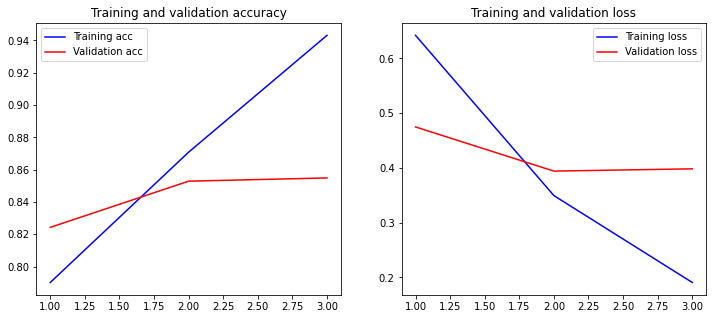

In [21]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

print(model.summary())
plot_history(history)

In [12]:
clear_session()
del model
del history
del loss
del accuracy
gc.collect()

8199

In [17]:
getrefcount(model)

NameError: name 'model' is not defined